In [0]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
!unzip images.zip

In [0]:
class RRTNet(nn.Module):
  def __init__(self, p=0.5):
    super(RRTNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
    self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
    self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
    self.fc1 = nn.Linear(4 * 4 * 128, 256)
    self.fc2 = nn.Linear(256 + 6, 2048)
    self.fc3 = nn.Linear(2048, 1024)
    self.fc4 = nn.Linear(1024, 512)
    self.fc5 = nn.Linear(512, 2)
    self.dropout = nn.Dropout(p)

  def forward(self, x):
    config_states, maps = x
    maps = maps.unsqueeze(1).float().to("cuda")
    config_states = config_states.float().to("cuda")
    x = F.max_pool2d(F.relu(self.conv1(maps)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = F.max_pool2d(F.relu(self.conv3(x)), 2)
    x = F.max_pool2d(F.relu(self.conv4(x)), 2)
    x = F.max_pool2d(F.relu(self.conv5(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = torch.cat((x, config_states), axis=1)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return x
  
  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

In [0]:
net = RRTNet(0.5).float().to("cuda")
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()
JHist = []

In [0]:
from dataloader import NonHolonomicDataset
from torch.utils.data import DataLoader
path = './'
dataset = NonHolonomicDataset('data.csv', path, grayscale=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [23]:
train_x, train_y = None, None
for j in range(100):
  for i, (input_data, labels) in enumerate(dataloader):
    y_labels = labels.float().to("cuda")
    
    optimizer.zero_grad()
    y_pred = net(input_data)

    loss = criterion(y_pred, y_labels)
    loss.backward()
    
    optimizer.step()
    epoch_loss = loss.item()
    JHist.append(epoch_loss)
    
    print(i + j * 119, epoch_loss)  

Streaming output truncated to the last 5000 lines.
6901 29.011930465698242
6902 27.88332748413086
6903 35.2669563293457
6904 18.29440689086914
6905 25.45231056213379
6906 28.90604591369629
6907 20.18644142150879
6908 30.145957946777344
6909 31.280807495117188
6910 26.393503189086914
6911 27.774168014526367
6912 29.808792114257812
6913 28.968055725097656
6914 29.586910247802734
6915 23.95162582397461
6916 31.698955535888672
6917 20.672035217285156
6918 27.11891746520996
6919 30.676284790039062
6920 29.49429702758789
6921 28.3753662109375
6922 25.90375518798828
6923 22.851821899414062
6924 22.044830322265625
6925 28.124011993408203
6926 24.345657348632812
6927 29.620624542236328
6928 26.19605255126953
6929 23.2529239654541
6930 19.03197479248047
6931 28.876073837280273
6932 30.69229507446289
6933 25.19336700439453
6934 36.171119689941406
6935 22.51012420654297
6936 25.987375259399414
6937 16.806447982788086
6938 25.09722137451172
6939 24.27367401123047
6940 22.29673194885254
6941 32.9041

In [0]:
# overfit on one batch
labels = labels.to("cuda").float()
for i in range(5000):
  optimizer.zero_grad()
  y_pred = net(input_data)
  loss = criterion(y_pred, labels)
  loss.backward()
  optimizer.step()
  epoch_loss = loss.item()
  print(i, epoch_loss)

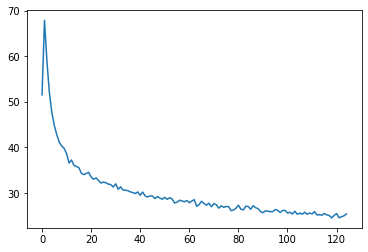

In [24]:
import matplotlib.pyplot as plt
JHist_avg = []
sum = 0
for index in range(30, len(JHist)):
  sum += JHist[index]
  if index % 99 == 0:
    JHist_avg.append(sum / 100)
    sum = 0

plt.plot(JHist_avg)

In [0]:
from google.colab import files
PATH = './RRTNet.pth'
torch.save(net.state_dict(), PATH)
files.download(PATH)